In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from correlate_recordings import FFT_SIZE

import pathlib

In [2]:
bands = [435, 436]
T_int = FFT_SIZE/40e3

def baseline_name(baseline):
    return '-'.join(baseline.split('_')[-2:])

def baseline_time(baseline):
    return np.datetime64(':'.join(baseline.split('_')[:3]))

In [3]:
results = pathlib.Path('results')
baselines = [str(f.name).replace('_correlations.npy', '') for f in results.glob('*_correlations.npy')]

In [4]:
def cluster(baselines, threshold = np.timedelta64(3600*4, 's')):
    times = [baseline_time(b) for b in baselines]
    s = sorted(zip(times, baselines), key = lambda z: z[0])
    clusters = []
    current = []
    old = None
    for t, b in s:
        if old is None:
            current = [b]
        elif t - old > threshold:
            clusters.append(current)
            current = [b]
        else:
            current.append(b)
        old = t
    if current:
        clusters.append(current)
    return clusters

In [5]:
clusters = cluster(baselines)

In [6]:
def plot_correlation_mag(baseline, ax, **kwargs):
    x = np.load(results / (baseline + '_correlations.npy'))
    t0 = np.load(results / (baseline + '_timing_info.npz'))['first_sample_timestamp']
    y = np.max(np.abs(x[..., 1:]), axis = (0,2))
    t = t0 + np.arange(y.size) * np.timedelta64(int(T_int * 1e9), 'ns')
    ax.plot(t, 20*np.log10(y), label = baseline_name(baseline), **kwargs)

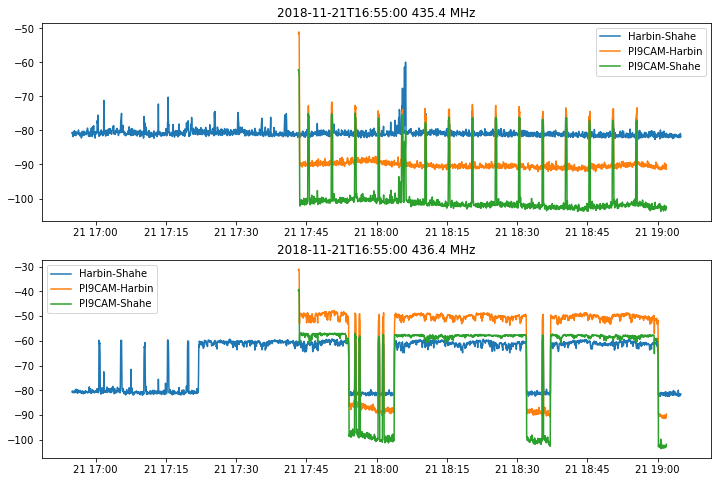

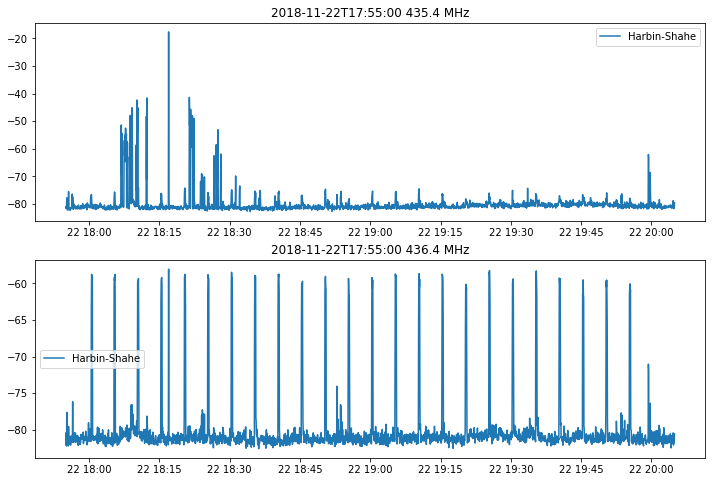

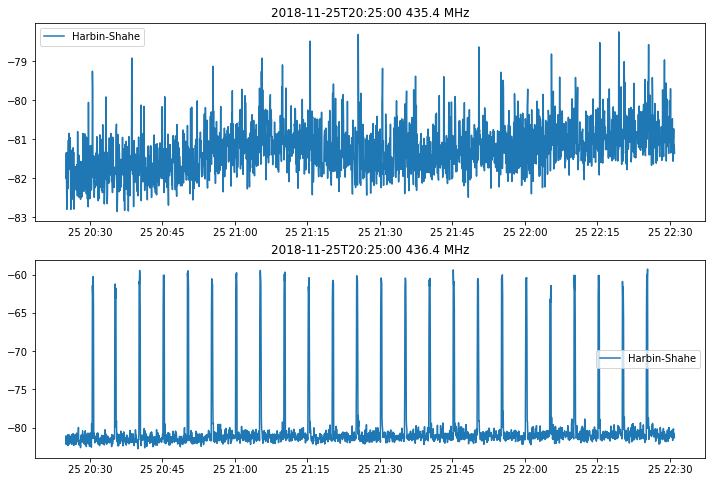

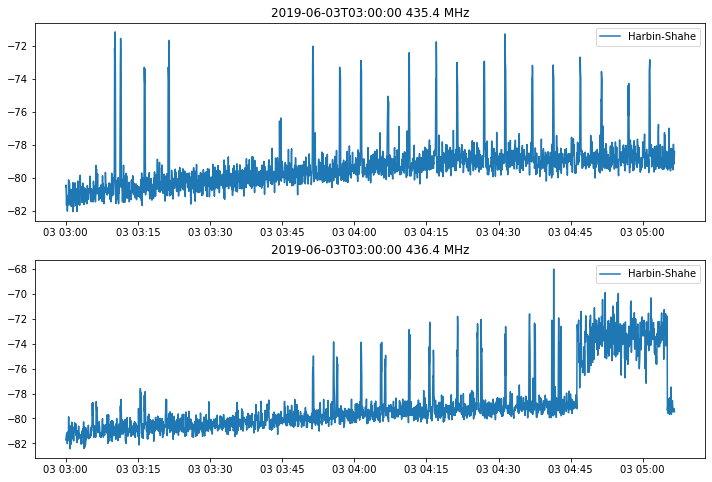

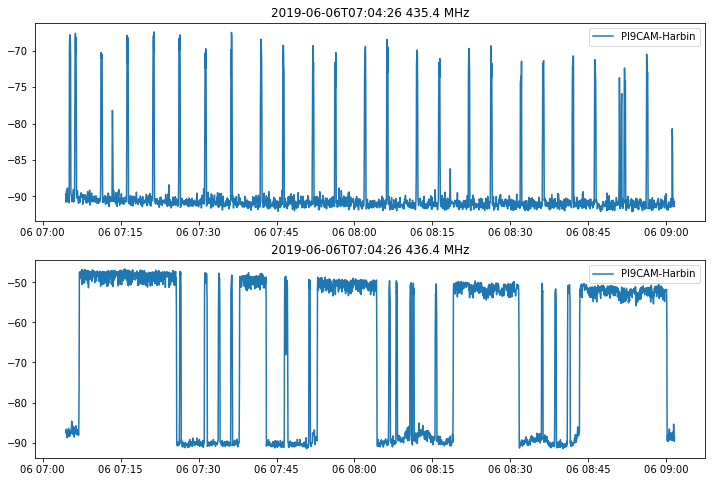

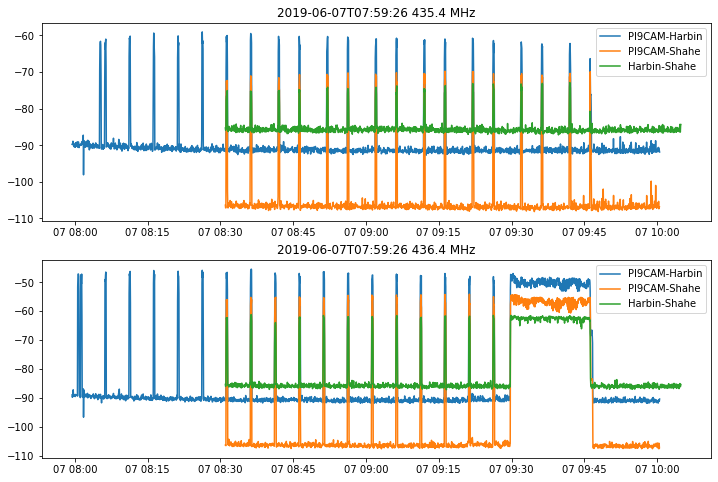

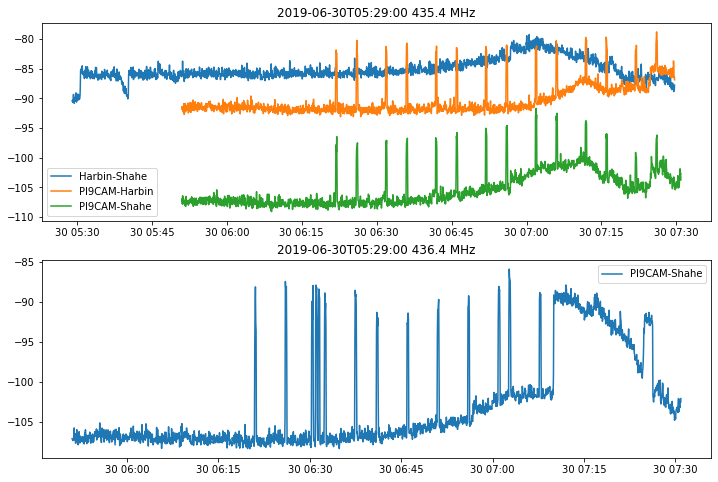

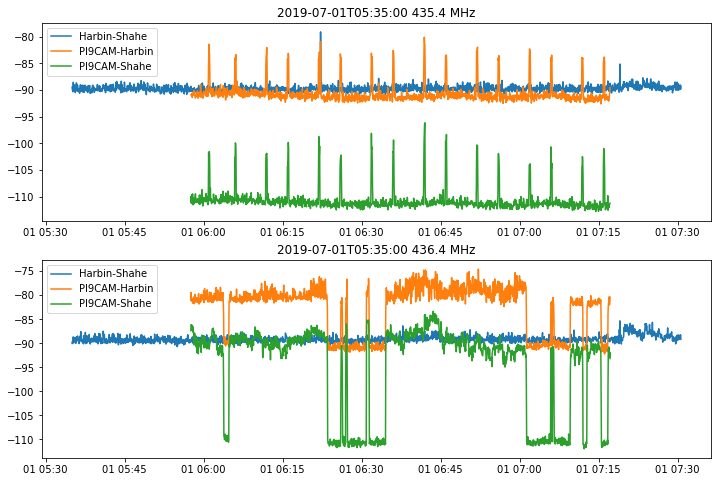

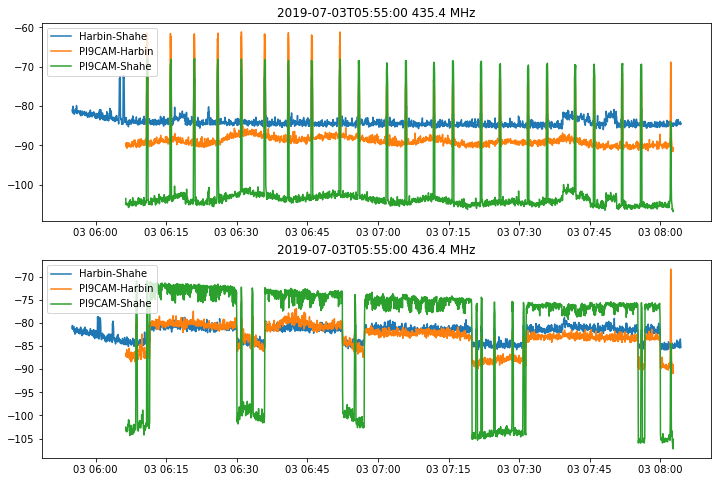

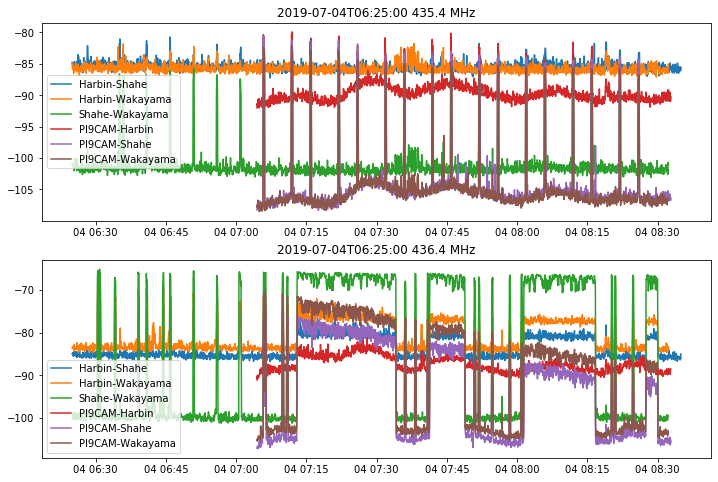

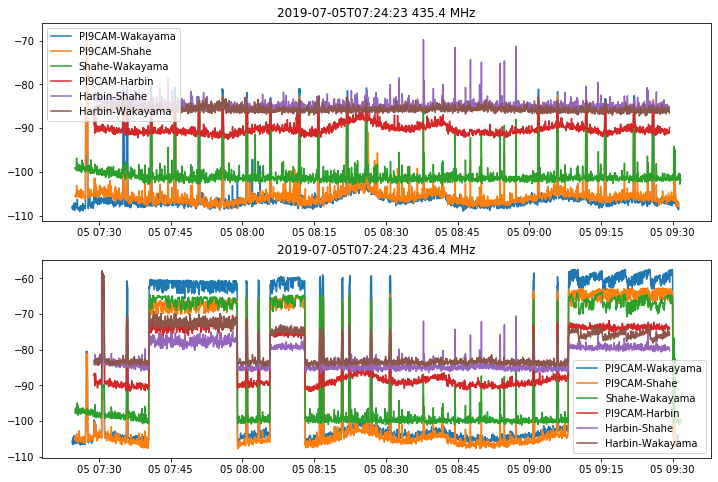

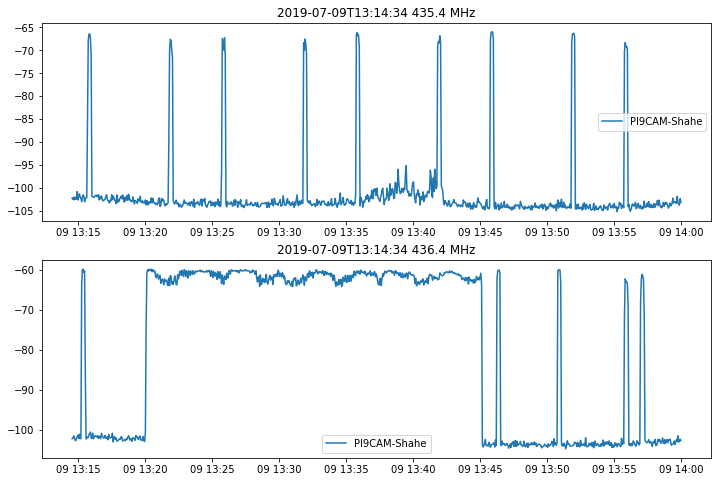

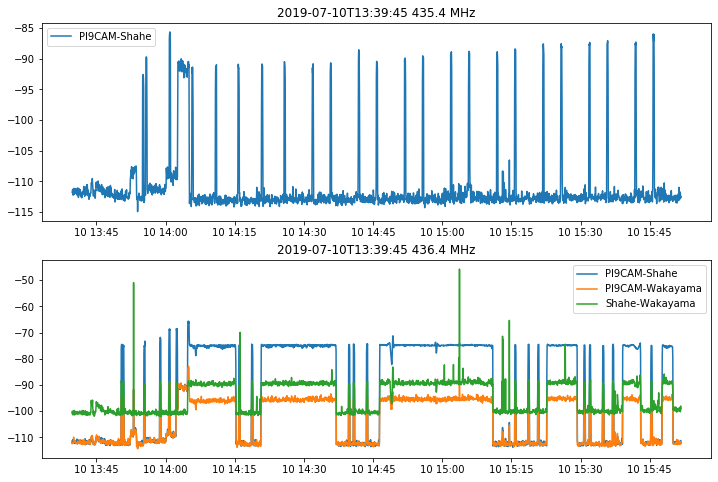

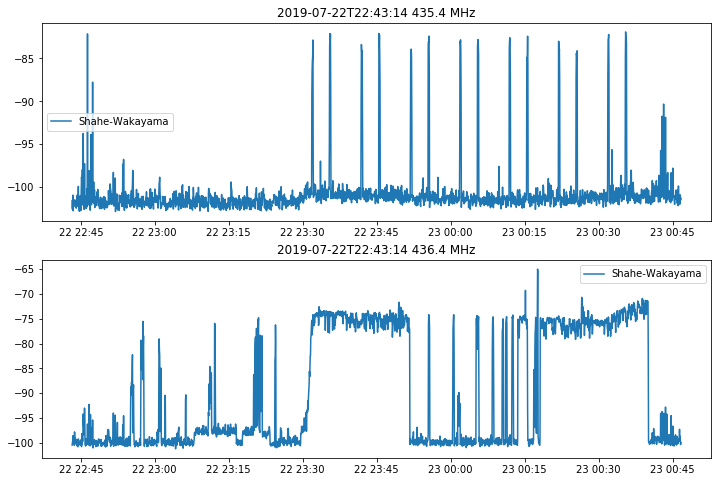

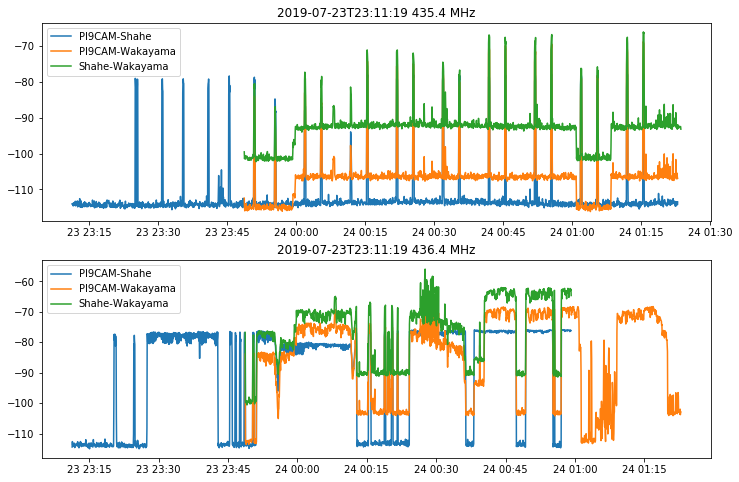

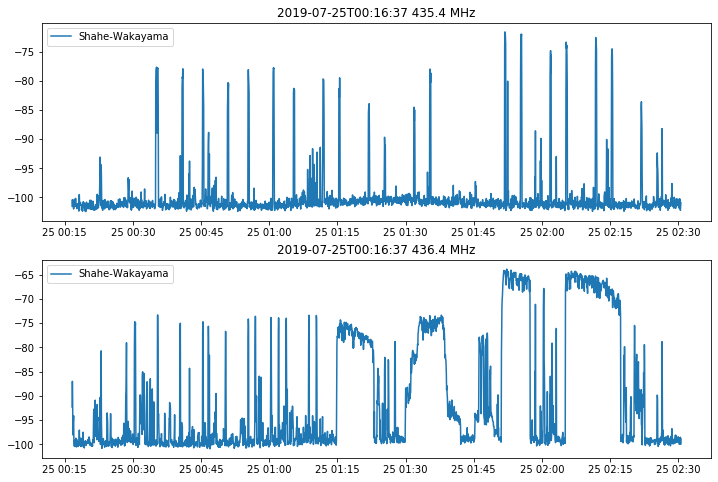

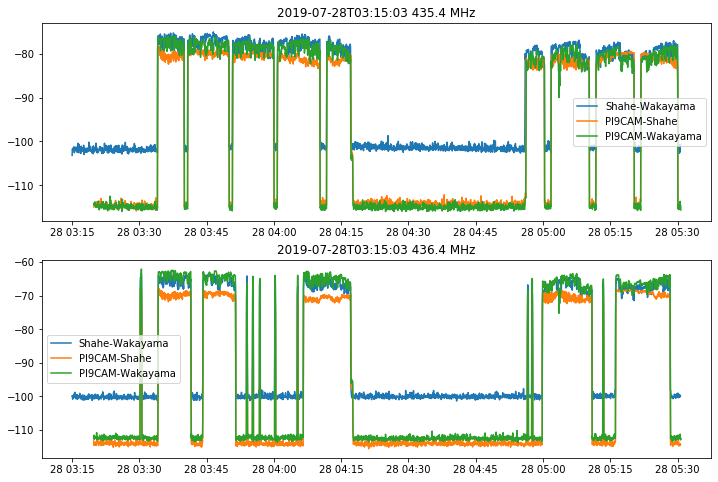

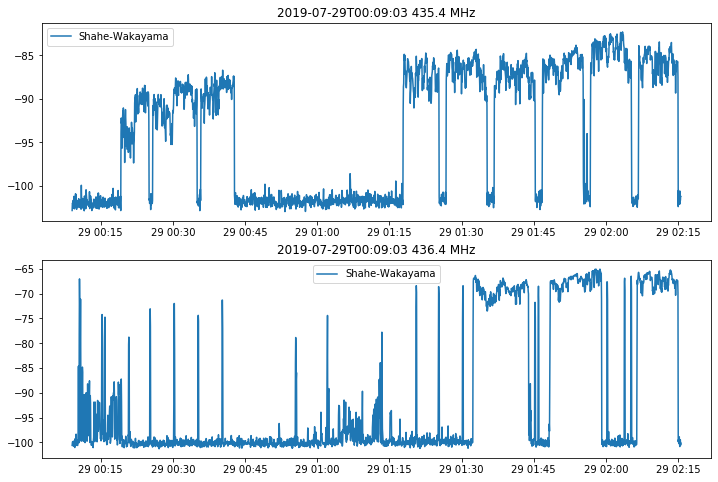

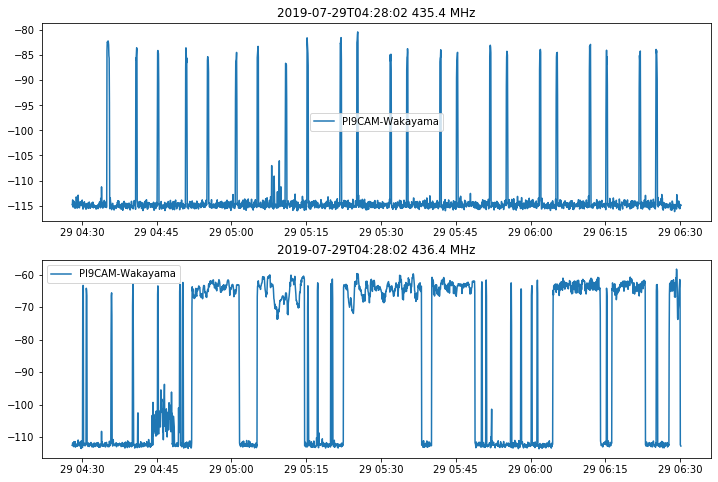

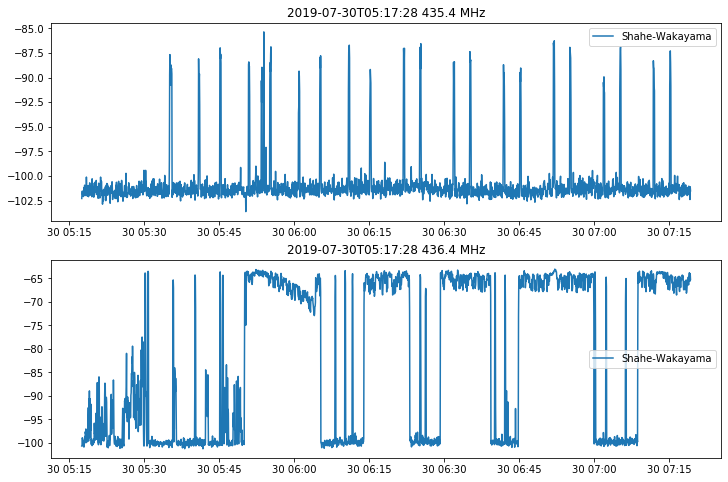

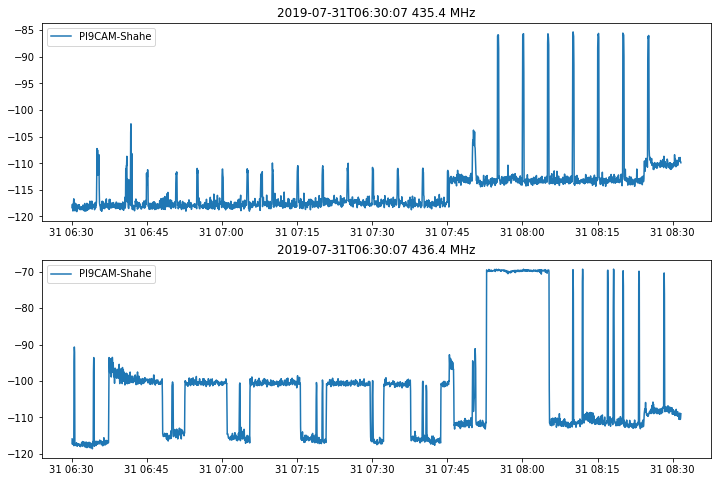

In [7]:
for obs in clusters:
    fig, axs = plt.subplots(len(bands), 1,figsize = (12,8))
    for ax, band in zip(axs,bands):
        for b in [b for b in obs if f'_{band}_' in b]:
            plot_correlation_mag(b, ax)
        ax.legend()
        ax.set_title(f'{baseline_time(obs[0])} {band}.4 MHz')